In [12]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:

# İstenilen sınıflar
classes = ['collie', 'dolphin', 'elephant', 'fox', 'moose', 'rabbit', 'sheep', 'squirrel', 'giant+panda', 'polar+bear']

# Kaggle veri yolu
data_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/"

# Sadece istenen sınıfları almak
selected_images = []

for class_name in os.listdir(data_dir):
    if class_name in classes:  # Sadece belirtilen sınıfları al
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):  # Eğer dizinse
            selected_images.append(class_dir)

# Şimdi selected_images listesi içinde sadece istediğiniz sınıflara ait dizinler var.
print(selected_images)


['/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/fox', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/giant+panda', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/polar+bear', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/elephant', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/sheep', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/collie', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/moose', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/rabbit', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/dolphin', '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/squirrel']


In [14]:
images = []
labels = []

for idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for i, img_name in enumerate(os.listdir(class_dir)):
        if i >= 650:  # Her sınıftan yalnızca 650 resim alınır
            break
        img_path = os.path.join(class_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (128, 128))  # 128x128 boyutlandırma
            images.append(img_resized)
            labels.append(idx)
        except Exception as e:
            print(f"Hata oluştu: {e}")


In [15]:
X = np.array(images, dtype='float32') / 255.0  # Normalizasyon
y = to_categorical(np.array(labels))  # One-hot encoding

# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Veri boyutlarını kontrol etme
print(f"X_train boyutu: {X_train.shape}")
print(f"X_test boyutu: {X_test.shape}")


X_train boyutu: (4550, 128, 128, 3)
X_test boyutu: (1950, 128, 128, 3)


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input

# Model oluşturma
model = Sequential([
    Input(shape=(64, 64, 3)),  # Giriş katmanını burada tanımlayın
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 sınıf
])


In [17]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Modelin oluşturulması
model = Sequential([
    Input(shape=(128, 128, 3)),  # Giriş katmanını burada tanımlayın
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')  # Çıkış katmanı
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator ile veri artırma tanımlamaları
datagen = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini [0, 1] aralığına getirme
    rotation_range=20,  # Rastgele döndürme
    width_shift_range=0.2,  # Genişlik kayması
    height_shift_range=0.2,  # Yükseklik kayması
    shear_range=0.2,  # Kaydırma
    zoom_range=0.2,  # Yakınlaştırma
    horizontal_flip=True,  # Yatay döndürme
    fill_mode='nearest'  # Doldurma modu
)

# EarlyStopping callback ekleyin
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğitin
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # batch_size artırıldı
    validation_data=(X_test, y_test),
    epochs=5,  # Daha az epoch ile başlanabilir
    callbacks=[early_stopping]  # EarlyStopping callback ekledik
)

# Eğitim sonrası test başarı oranı hesaplanabilir
y_pred = model.predict(X_test)  # Test verisi üzerinde tahmin yapma
test_accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))  # Argmax ile sınıf tahminini al
print(f"Test Başarısı: {test_accuracy}")


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 573ms/step - accuracy: 0.0919 - loss: 2.3034 - val_accuracy: 0.0944 - val_loss: 2.6514
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 552ms/step - accuracy: 0.0944 - loss: 2.3026 - val_accuracy: 0.0938 - val_loss: 2.6498
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 551ms/step - accuracy: 0.1072 - loss: 2.3026 - val_accuracy: 0.0938 - val_loss: 2.6490
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 549ms/step - accuracy: 0.1076 - loss: 2.3022 - val_accuracy: 0.0938 - val_loss: 2.6476
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 552ms/step - accuracy: 0.1043 - loss: 2.3025 - val_accuracy: 0.0964 - val_loss: 2.6473
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step
Test Başarısı: 0.09641025641025641


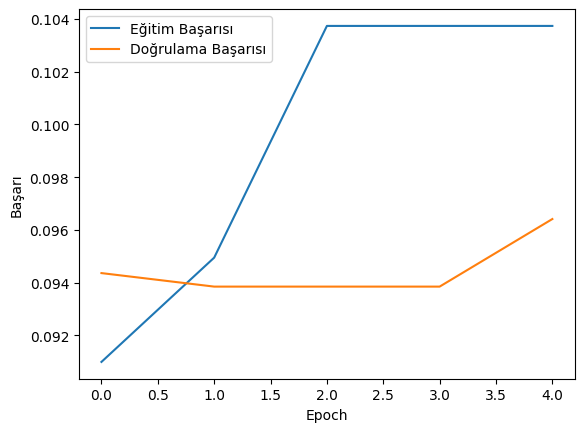

In [20]:
# Eğitim ve doğrulama başarılarının görselleştirilmesi
plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarısı')
plt.xlabel('Epoch')
plt.ylabel('Başarı')
plt.legend()
plt.show()


In [21]:
def get_manipulated_images(X_test):
    manipulated_images = []
    for img in X_test:
        # Örnek olarak parlaklığı artırma
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=50)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

manipulated_X_test = get_manipulated_images(X_test)
manipulated_y_pred = model.evaluate(manipulated_X_test, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.1059 - loss: 76.3579


In [22]:
def apply_gray_world(img):
    # Gray World algoritması
    img = img.astype(np.float32)
    avg_rgb = np.mean(img, axis=(0, 1))
    avg_gray = np.mean(avg_rgb)
    scale = avg_gray / avg_rgb
    return (img * scale).clip(0, 255).astype(np.uint8)

wb_X_test = np.array([apply_gray_world(img) for img in manipulated_X_test])
wb_y_pred = model.evaluate(wb_X_test, y_test)


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.1059 - loss: 75.8323


In [23]:
print(f"Orijinal Test Başarısı: {history.history['val_accuracy'][-1]}")
print(f"Manipüle Test Başarısı: {manipulated_y_pred[1]}")
print(f"Renk Sabitliği Sonrası Test Başarısı: {wb_y_pred[1]}")

Orijinal Test Başarısı: 0.09641025960445404
Manipüle Test Başarısı: 0.1035897433757782
Renk Sabitliği Sonrası Test Başarısı: 0.1035897433757782
